<a href="https://colab.research.google.com/github/simulate111/Rice/blob/main/Exercise_MLPR2024_part1_example_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise work consists of three parts. After each part, take the mini-exam available in Moodle. The questions concern the exercise so read the instructions carefully and make sure you remember to cover all given tasks. <br>
After the deadline of each mini-exam, example results will be published. This helps you to move to the next part. However, take into account that the deadlines are thus strict, no extensions will be granted! <br>
Two exam points can be acquired from each mini-exam. All three parts of the exercise are compulsory. Completed exercise work from previous years does not apply for this course.

**Deadlines for the mini-exams:**
- Part 1: Fri 9.2.2024 at 23:59
- Part 2: Fri 23.2024 at 23:59
- Part 3: Fri 8.3.2024 at 23:59

**If you encounter problems, Google first and if you can’t find an answer, ask for help**
- Moodle area for questions
- pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives at maximum 6 points, i.e. the total score is 36 points.

# Part 1

Read the original research article:

İ. Çınar and M. Koklu. Identification of rice varieties using machine learning algorithms. Journal of Agricultural Sciences, 28(2):307–325, 2022. doi: 10.15832/ankutbd.862482.

https://dergipark.org.tr/en/download/article-file/1513632

There will be questions regarding the article in the mini-exam.

Mini-exam questions:<br>

**1. The camera used to take the rice images was placed in a closed box. Why?** <br>
Answer: To ensure the same lighting environment for all rice samples.
<br>

**2. Which morphological feature is: The number of pixels in the smallest convex polygon that can accommodate the rice grain area?** <br>
Answer: Convex_Area

**3. How many color spaces were used to derive the color features in the original article?** <br>
Answer: 5

## Introduction

Will be written in Part 3.

## Preparations of the data

Make three folders in your working folder: 'notebooks', 'data' and 'training_data'. Save this notebook in 'notebooks' folder.

Import all the packages needed for this notebook in one cell (add the ones you apply):

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv

import glob, os
import itertools

from random import sample
from random import seed

from scipy.stats import skew
from scipy.stats import kurtosis

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import the images. Data can be found from (downloading starts as you press the link) https://www.muratkoklu.com/datasets/vtdhnd09.php <br>
Save the data folders 'Arborio', 'Basmati', 'Ipsala', 'Jasmine', and 'Karacadag' in 'data' folder. <br>
Take a random sample of 100 images from each rice species (i.e. 500 images in total). Use seed(50) for enabling reproducible results.

In [ ]:
# import data
# set the seed for enabling
# the reproduction with the same sequence
seed(50)

path = '../data'
folders = ['Arborio',
           'Basmati',
           'Ipsala',
           'Jasmine',
           'Karacadag']

subset = []
for folder in folders:
    path_folder = os.path.join(path, folder)
    # all .jpg files from the given folder
    files = glob.glob(os.path.join(path_folder, '*.jpg'))
    # gather all sampled filenames in subset list
    subset.extend(sample(files, 100))

 Gather the sampled images in a list.

In [ ]:
# gather images
ims = []
for filename in subset:
    # image in BGR order
    im = cv.imread(filename)
    ims.append(im)

We will test the needed functions with one test image. It is 'basmati (244).jpg'. Save this image as test_image.

In [ ]:
test_image_file_name = '../data/Basmati/basmati (244).jpg'
test_image = cv.imread(test_image_file_name)

Determine the contour of each rice (use *findContours* from OpenCV). <br>
Determine the contour also for the test_image. <br>
Plot the original image of the test_image and also its image including the contour. <br>
Be aware that *drawContours* adds the contour to the original image, so use the copy of the test_image as input for the function!

In [ ]:
# https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html
def find_contour(im):
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh,
                                          cv.RETR_TREE,
                                          cv.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    return(cnt.reshape(-1,2))

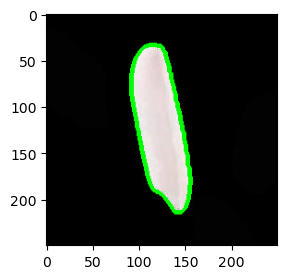

In [ ]:
# find contour for the test_image
test_image_cnt = find_contour(test_image)
plt.figure(figsize=(3,3))
# drawCountours arguments:
#image, contours, index of contours, color, thickness
plt.imshow(cv.drawContours(test_image.copy(),
                           [test_image_cnt], 0, (0,255,0), 3));

Mini-exam question: <br>
**4. Compare the contours below. Which one is the contour of the test_image?** <br>
Answer: See thes image below, the contour is the first one (you may have had the images in different order in your mini-exam).

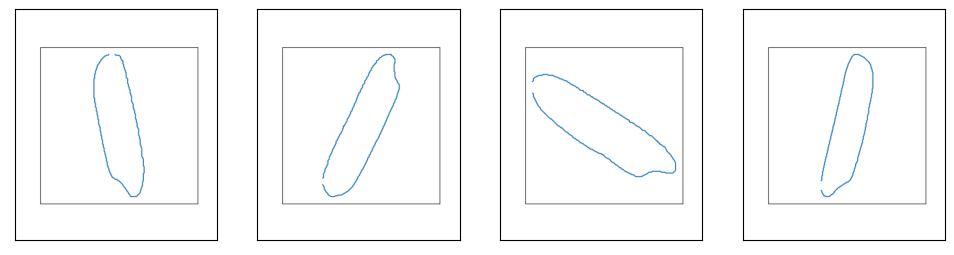

In [ ]:
plt.figure(figsize=(12,3))
for i, im_opt in enumerate(['opt1.png',
                            'opt2.png',
                            'opt3.png',
                            'opt4.png']):
    plt.subplot(1,4,i+1)
    im_opt = plt.imread('opt{}.png'.format(i+1))
    plt.imshow(im_opt)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])

In [ ]:
# find contour for each image in the subset
contour_images = []
cnts = []
ims_with_contours = []
for im in ims:
    # take a copy of the original image
    # in order to avoid adding the contour to the original image
    im = im.copy()
    cnt = find_contour(im)
    cnts.append(cnt)
    ims_with_contours.append(cv.drawContours(im,
                                             [cnt],
                                             0, (0,255,0), 3))

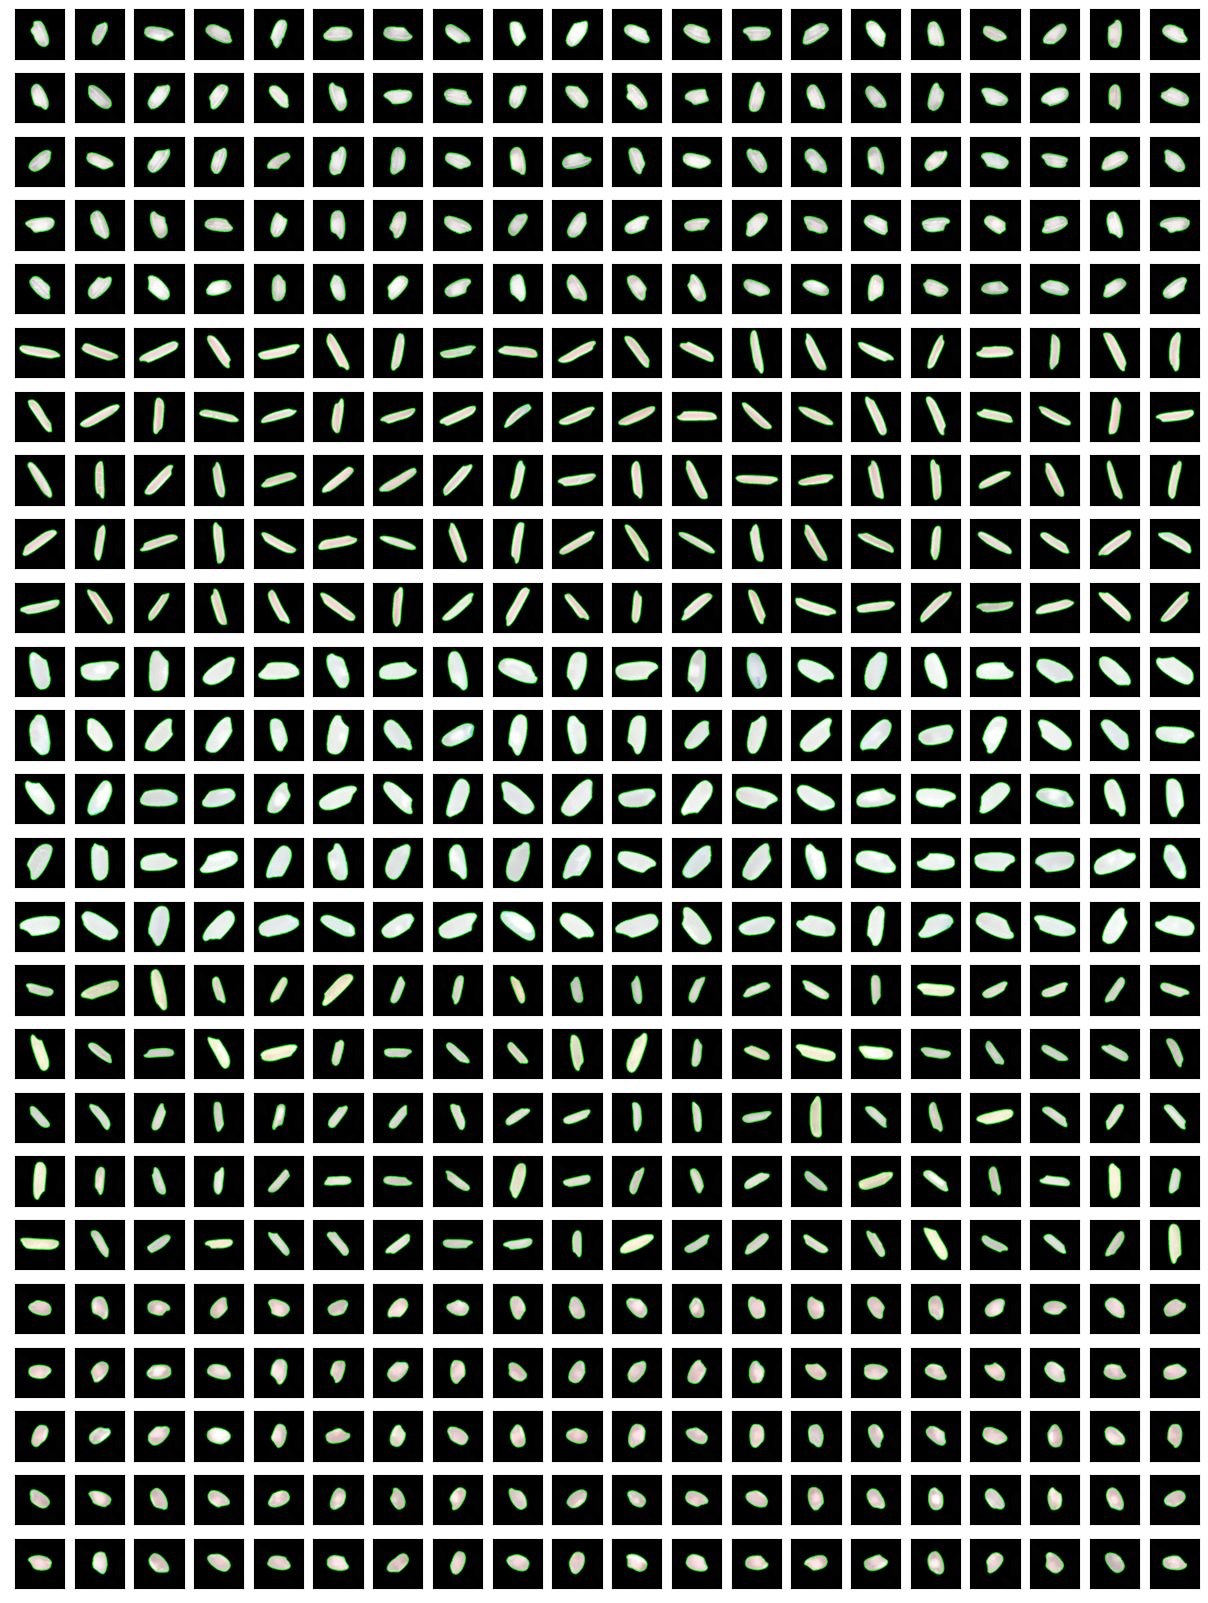

In [ ]:
# just to check that all of the contours look reasonable
i = 0
fig = plt.figure(figsize=(12, 16))
for im in ims_with_contours:
    i+=1
    plt.subplot(25, 20, i)
    plt.imshow(im)
    #get current axes
    ax = plt.gca()
    #hide axes
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.4);

## Feature extraction

Gather the color feature data (12 features): <br>

First, convert each RGB image to YCbCr-image. You can use *cvtColor* function from OpenCV with appropriate color conversion. <br>
Be aware that openCV default channel order is BGR not RGB. In which order does the *cvtColor* function output the components? <br>

Calculate the following color features for each image, including only the pixels within the contour (you can use *pointPolygonTest* from OpenCV)
- Mean for each YCbCr component
- Variance for each YCbCr component
- Skewness for each YCbCr component
- Kurtosis for each YCbCr component

Is point x = 125, y = 160 within the contour in the test_image? (x is in horizontal direction, y is in vertical direction)

1.0


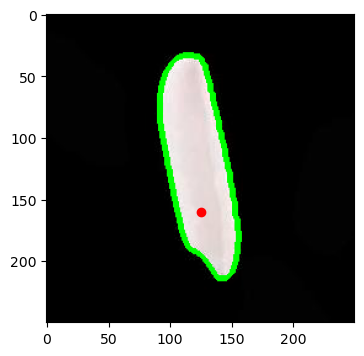

In [ ]:
x = 125
y = 160

print(cv.pointPolygonTest(test_image_cnt, (x,y), False))
plt.figure(figsize=(4,4))
plt.imshow(cv.drawContours(test_image.copy(),
                           [test_image_cnt], 0, (0,255,0), 3))
plt.plot(x,y,'ro');

Mini-exam question: <br>
**5. Is the point x = 125, y = 160 within the contour of the test_image? (x = horizontal pixel, y = vertical pixel)** <br>
Answer: Yes

In [ ]:
def calc_color_features(im, cnt, component):

    # change from BGR into YCrCb color space
    im_ycrcb = cv.cvtColor(im, cv.COLOR_BGR2YCrCb)

    xs = range(0, im.shape[1])
    ys = range(0, im.shape[0])

    xys = list(itertools.product(xs, ys))

    # gather the pixels which are within the contour to a list
    comp_values = []
    for x, y in xys:

        # check if the point (x,y) is within the contour.
        # Pixels in image [y, x, color_channel]
        if cv.pointPolygonTest(cnt, (x,y), False) == 1:
            comp_values.append(im_ycrcb[y, x, component])

    return(np.mean(comp_values),
           np.var(comp_values),
           skew(comp_values),
           kurtosis(comp_values))

What are the mean values of Y, Cb and Cr components for the test image (within the contour)?

In [ ]:
print('Y:', calc_color_features(test_image, test_image_cnt, 0)[0])
print('Cb:', calc_color_features(test_image, test_image_cnt, 2)[0])
print('Cr:', calc_color_features(test_image, test_image_cnt, 1)[0])

Y: 223.9083980044346
Cb: 133.6614467849224
Cr: 126.87860310421286


Miniexam question: <br>
**6. The mean value of Cr component is...** <br>
Answer: Almost the same as Cb component value.

Gather the dimension feature data (8 features) <br>
- Fit an ellipse to the contour points (use *fitEllipse* from OpenCV)
- Plot one example image of each rice species including the fitted ellipse
- Calculate the following features for each image (for details, see the original article)
    - the major axis length the ellipse
    - the minor axis length of the ellipse
    - area inside the contour (use *contourArea* from OpenCV)
    - perimeter of the contour (use *arcLength* from OpenCV)
    - equivalent diameter
    - compactness
    - shape factor 1 (SF1)
    - shape factor 2 (SF2)
    
Calculate the dimension feature values for the test_image as well. What are the dimension feature values for the test_image?

In [ ]:
def calc_dimension_features(im, cnt):

    # fit an ellipse to the contour.
    # Ellipse is a tuple including
    # (center coordinates, axes lengths, angle)
    ellipse = cv.fitEllipse(cnt)
    (cc, (a1, a2), ang) = ellipse

    major_a = max(a1, a2)
    minor_a = min(a1, a2)

    fig = cv.ellipse(im.copy(), ellipse, (0,0,255), 3)

    area = cv.contourArea(cnt)
    perimeter = cv.arcLength(cnt, True)

    equivalent_diameter = np.sqrt((4 * area) / (np.pi))
    compactness = equivalent_diameter / major_a

    shape_factor1 = major_a / area
    shape_factor2 = minor_a / area


    return(pd.DataFrame(
        data={'major_axis_length': [major_a],
              'minor_axis_length': [minor_a],
              'area': [area],
              'perimeter': [perimeter],
              'equivalent_diameter': [equivalent_diameter],
              'compactness': [compactness],
             'shape_factor1': [shape_factor1],
             'shape_factor2': [shape_factor2]}), fig)

In [ ]:
calc_dimension_features(test_image, test_image_cnt)[0]

,major_axis_length,minor_axis_length,area,perimeter,equivalent_diameter,compactness,shape_factor1,shape_factor2
0,194.516296,50.020149,7409.5,430.835568,97.129133,0.499337,0.026252,0.006751


Gather all the features in a dataframe: one sample in one row, including all feature values in columns. <br>
For each data point, include also information of the original image and the label (rice species). <br>
Save the data in training_data folder as a parquet file.

In [ ]:
def gather_color_features(im, cnt):

    df = []

    for component, abbr in enumerate(['y', 'cr', 'cb']):

        c_mean, c_var, c_skew, c_kurt = calc_color_features(
            im, cnt, component)

        df.append(pd.DataFrame(
            data={'mean_{}'.format(abbr) : [c_mean],
                  'var_{}'.format(abbr) : [c_var],
                  'skew_{}'.format(abbr) : [c_skew],
                  'kurt_{}'.format(abbr) : [c_kurt]
                       }))

    df = pd.concat(df, axis=1)

    return(df)

In [ ]:
# calculate all features and gather them as a dataframe
df = []
ims_with_ellipses = []
for cnt, filename, im in zip(cnts, subset, ims):
    # color features
    df1 = gather_color_features(im, cnt)

    # dimension features
    df2, fig = calc_dimension_features(im, cnt)
    ims_with_ellipses.append(fig)

    df3 = pd.concat([df1, df2], axis=1)
    df3['class'] = [filename[8:11]]

    df.append(df3)
    print('Features derived for', filename)

df = pd.concat(df, axis=0, ignore_index=True)
df['class_int']= df['class'].map(
    {'Arb': 0, 'Bas':1, 'Ips':2, 'Jas': 3, 'Kar':4})

Features derived for ../data\Arborio\Arborio (3834).jpg
Features derived for ../data\Arborio\Arborio (9115).jpg
Features derived for ../data\Arborio\Arborio (13922).jpg
Features derived for ../data\Arborio\Arborio (1867).jpg
Features derived for ../data\Arborio\Arborio (5898).jpg
Features derived for ../data\Arborio\Arborio (9634).jpg
Features derived for ../data\Arborio\Arborio (13573).jpg
Features derived for ../data\Arborio\Arborio (671).jpg
Features derived for ../data\Arborio\Arborio (3475).jpg
Features derived for ../data\Arborio\Arborio (7806).jpg
Features derived for ../data\Arborio\Arborio (14865).jpg
Features derived for ../data\Arborio\Arborio (11253).jpg
Features derived for ../data\Arborio\Arborio (4438).jpg
Features derived for ../data\Arborio\Arborio (14678).jpg
Features derived for ../data\Arborio\Arborio (13306).jpg
Features derived for ../data\Arborio\Arborio (6472).jpg
Features derived for ../data\Arborio\Arborio (4706).jpg
Features derived for ../data\Arborio\Arbori

In [ ]:
df.to_parquet('../training_data/rice_feature_data.parquet')

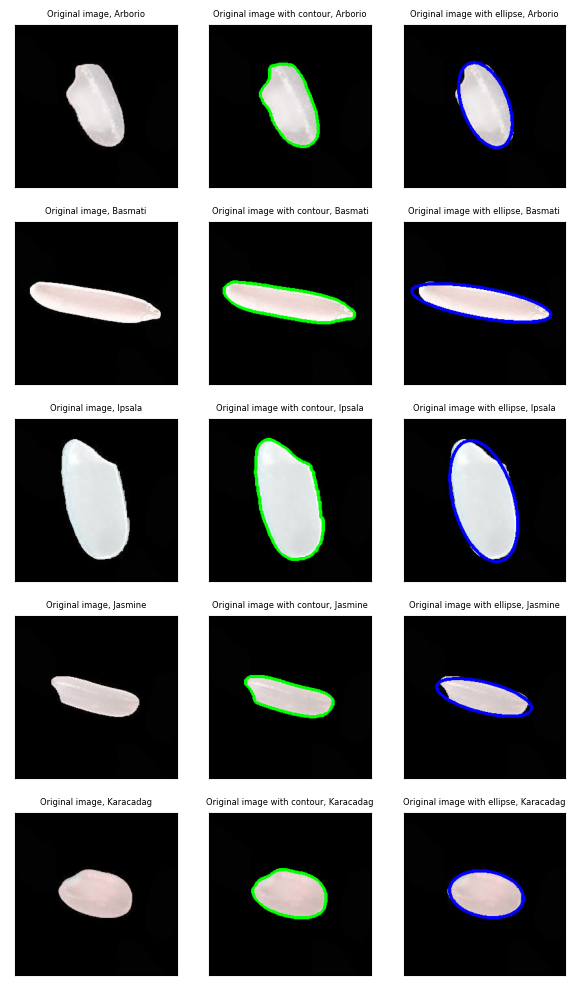

In [ ]:
# plot one example of an original image and
# the original image with the contour and
# the original image with the ellipse
plt.figure(figsize=(6, 10))
chosen_images = [0, 100, 200, 300, 400]
roll = 0
for i, species in zip(chosen_images, folders):
    roll+=1
    im = ims[i]
    imc = ims_with_contours[i]
    ime = ims_with_ellipses[i]

    plt.subplot(5,3,roll)
    plt.title('Original image, {}'.format(species), fontsize=6)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

    roll+=1

    plt.subplot(5,3,roll)
    plt.title('Original image with contour, {}'.format(species),
              fontsize=6)
    plt.imshow(imc)
    plt.xticks([])
    plt.yticks([])

    roll+=1

    plt.subplot(5,3,roll)
    plt.title('Original image with ellipse, {}'.format(species),
              fontsize=6)
    plt.imshow(ime)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout();

Determine the maximum variance of the Cr component for each rice species. Which rice species has the smallest value?

In [ ]:
df.groupby('class').var_cr.max()

class
Arb     1.599300
Bas     7.692872
Ips     5.612974
Jas    15.464937
Kar     1.858648
Name: var_cr, dtype: float64

Mini-exam question: <br>
**7. Determine the maximum variance of the Cr component for each rice species. Which rice species has the smallest value?** <br>
Answer: Arborio

Determine the minimum equivalent diameter for each rice species. Which rice species has the largest value?

In [ ]:
df.groupby('class').equivalent_diameter.min()

class
Arb     81.223708
Bas     81.805544
Ips    113.647446
Jas     78.513625
Kar     81.011809
Name: equivalent_diameter, dtype: float64

Mini-exam question: <br>
**8. Determine the minimum equivalent diameter for each rice species. Which rice species has the largest value?** <br>
Answer: Ipsala

Determine the minimum, maximum and median equivalent diameter for Basmati rice samples. <br>
Compare the equivalent diameter value of the test_image to these values. <br>

In [ ]:
df[df.class_int == 1].equivalent_diameter.describe()

count    100.000000
mean      95.734143
std        5.637933
min       81.805544
25%       92.061480
50%       96.444960
75%       99.973800
max      106.250546
Name: equivalent_diameter, dtype: float64

Mini-exam question: <br>
**9. Determine the minimum, maximum and median equivalent diameter for Basmati. Where in this range does the equivalent diameter of the test_image lie?** <br>
Answer: The equivalent diameter for the test image is 97 pixels. Thus, the value is close to the median value of the equivalent diameter for Basmati samples.

Does a high value of compactness mean that the rice is rather round or thin?

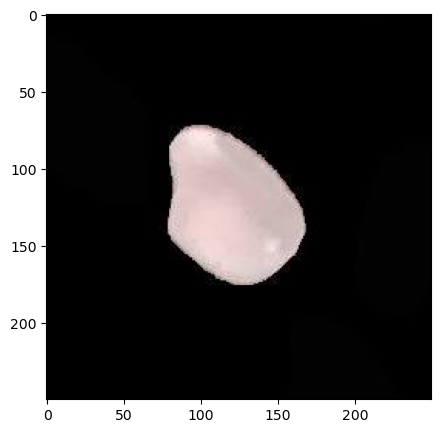

In [ ]:
# a high value of compactness
plt.figure(figsize=(5,5))
plt.imshow(ims[df[
    df.compactness == df.compactness.max()].index[0]]);

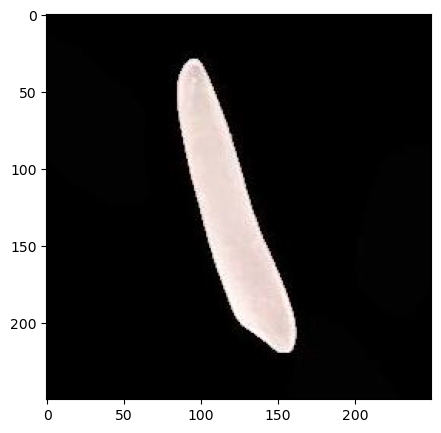

In [ ]:
# a small value of compactness
plt.figure(figsize=(5,5))
plt.imshow(ims[df[
    df.compactness == df.compactness.min()].index[0]]);

Mini-exam question: <br>
**10. Does a high value of compactness mean that the rice is rather round or thin?** <br>
Answer: Round